# Data loading 
Next cells are used to load the data we need.

In [1]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')


In [2]:
#data which contains users (row), items(col) and implicit interaction (data)
dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


# Data pre-processing
Pre-processing of data to check for missing users, items ecc...

In [3]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

In [4]:
ICM_df = pd.read_csv('data_ICM_title_abstract.csv')
ICM_df

,row,col,data
0,0,1185,1.015524
1,0,2507,0.459024
2,0,3534,0.227742
3,0,8766,0.501549
4,0,10862,0.297011
...,...,...,...
490686,25974,12554,0.963016
490687,25974,13003,0.104613
490688,25974,16236,0.118760
490689,25974,18797,0.363301


In [5]:
items = ICM_df.row
features = ICM_df.col
data = ICM_df.data
ICM_all = sps.coo_matrix((data, (items, features)))
ICM_all = ICM_all.tocsr() #fast row access -> fast access to users 
ICM_all.shape

(25975, 20000)

In [6]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

#splitting data into train and validation (from the previous training data)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)



In [7]:
URM_all

<7947x25975 sparse matrix of type '<class 'numpy.float64'>'
	with 113268 stored elements in Compressed Sparse Row format>

In [8]:
ICM_all

<25975x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 490691 stored elements in Compressed Sparse Row format>

In [9]:
#evaluator for validation (used for hyperparameter tuning)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

In [11]:
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender
recommender = PureSVDRecommender(URM_train)
recommender.fit(num_factors = 825)


PureSVDRecommender: URM Detected 27 (0.34 %) cold users.
PureSVDRecommender: URM Detected 1966 (7.57 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!


In [49]:
user_factor = recommender.USER_factors

super_threshold_indices = abs(user_factor) < 0.001
user_factor[super_threshold_indices] = 0

non_zero = np.count_nonzero(user_factor)
print(non_zero)

zero = np.count_nonzero(user_factor==0)
print(zero)

user_factor = sps.csr_matrix(user_factor)

3948712
2607563


In [51]:
user_factor

<7947x825 sparse matrix of type '<class 'numpy.float32'>'
	with 3948712 stored elements in Compressed Sparse Row format>

In [55]:
from KNN.UserKNNCFRecommender import UserKNNCFRecommender
recommender = UserKNNCFRecommender(user_factor)
recommender.fit(shrink=0, topK=100)
recommender.W_sparse
#evaluator_validation.evaluateRecommender(recommender) #finire, potrebbe esser n'idea 

UserKNNCFRecommender: URM Detected 226 (2.84 %) cold users.
Compute_Similarity: detected dense matrix
Similarity column 7947 ( 100 % ), 1024.61 column/sec, elapsed time 0.13 min


<7947x7947 sparse matrix of type '<class 'numpy.float32'>'
	with 772100 stored elements in Compressed Sparse Row format>

In [11]:
x_tick = []
collaborative_MAP = []

for num_factors in [20,50,100,200,300,500,800,825,850,875,900,1000]:
    
    x_tick.append("num_factors {}".format(num_factors))

    recommender.fit(num_factors = num_factors)

    result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

    collaborative_MAP.append(result_dict[10]["MAP"])

PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!


KeyboardInterrupt: 

In [28]:
#7 0.037385194759385246 num_factors 825
import operator
index, value = max(enumerate(collaborative_MAP), key=operator.itemgetter(1))
print(index, value)
parameters = x_tick[index]
print(parameters)

7 0.037385194759385246
num_factors 825


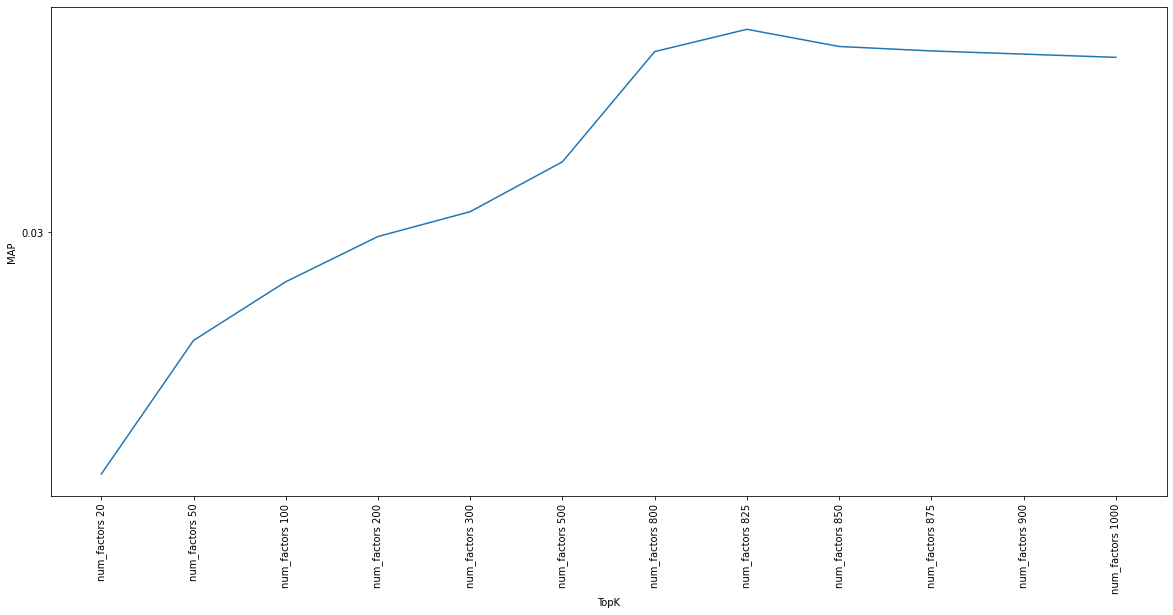

In [29]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(20, 9))
plt.plot(x_tick, collaborative_MAP, label="Collaborative")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.ylabel('MAP')
plt.xlabel('TopK')
plt.xticks(rotation='vertical')
plt.show()

In [12]:
test_users = pd.read_csv('data_target_users_test.csv')
test_users

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
7939,7942
7940,7943
7941,7944
7942,7945


In [17]:
recommender = recommender = PureSVDRecommender(URM_all)
recommender.fit(num_factors=825)

user_id = test_users['user_id']
recommendations, scores = recommender.recommend(user_id,cutoff = 10, return_scores = True)


PureSVDRecommender: URM Detected 1079 (4.15 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!


In [27]:
print(scores.max(axis=1).mean())
print(scores.max(axis=1).std())

0.10558129
0.118685886


C:\Users\Mattia\anaconda3\envs\rec_sys\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


nan


In [ ]:
for index in range(len(recommendations)):
    #print(element)
    recommendations[index]=np.array(recommendations[index])
    #print(type(element))
print(len(recommendations))

In [ ]:
test_users['item_list']= recommendations
#test_users['item_list'] =  test_users['item_list'].apply(lambda x: x.replace('[','').replace(']','')) 
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])

#convert the string columns to int
#test_users['item_list'] = test_users['item_list'].astype(int)
test_users
test_users.to_csv('submission.csv', index=False)


# Funk SVD test 

In [ ]:
from MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_FunkSVD_Cython
recommender = MatrixFactorization_FunkSVD_Cython(URM_train)
recommender.fit(epochs = 100, num_factors = 200, use_bias = True,  user_reg = 0.1, item_reg = 0.1)

MatrixFactorization_FunkSVD_Cython_Recommender: URM Detected 34 (0.43 %) cold users.
MatrixFactorization_FunkSVD_Cython_Recommender: URM Detected 2004 (7.72 %) cold items.
FUNK_SVD: Processed 96000 ( 98.97% ) in 1.72 seconds. MSE loss 9.40E-01. Sample per second: 55704
FUNK_SVD: Epoch 1 of 100. Elapsed time 1.40 sec
FUNK_SVD: Processed 96000 ( 98.97% ) in 2.34 seconds. MSE loss 7.78E-01. Sample per second: 41105
FUNK_SVD: Epoch 2 of 100. Elapsed time 3.01 sec
FUNK_SVD: Processed 96000 ( 98.97% ) in 1.79 seconds. MSE loss 6.43E-01. Sample per second: 53762
FUNK_SVD: Epoch 3 of 100. Elapsed time 4.46 sec
FUNK_SVD: Processed 96000 ( 98.97% ) in 2.09 seconds. MSE loss 5.33E-01. Sample per second: 45869
FUNK_SVD: Epoch 4 of 100. Elapsed time 5.76 sec
FUNK_SVD: Processed 96000 ( 98.97% ) in 1.40 seconds. MSE loss 4.43E-01. Sample per second: 68515
FUNK_SVD: Epoch 5 of 100. Elapsed time 7.07 sec
FUNK_SVD: Processed 96000 ( 98.97% ) in 1.75 seconds. MSE loss 3.68E-01. Sample per second: 54963


In [ ]:
evaluator_validation.evaluateRecommender(recommender)